# 第3部　基本的な時系列予測の手法

## 第3章　sktimeの使い方

### 分析の準備

In [1]:
# 数値計算に使うライブラリ
import numpy as np
import pandas as pd

# グラフを描画するライブラリ
from matplotlib import pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
sns.set()

# データ読み込みに利用
import statsmodels.api as sm

# sktime：グラフ描画
from sktime.utils.plotting import plot_series

# sktime：予測
from sktime.forecasting.naive import NaiveForecaster
from sktime.forecasting.trend import PolynomialTrendForecaster

# sktime：予測の評価指標
from sktime.performance_metrics.forecasting import (
    mean_absolute_scaled_error, MeanAbsoluteError,
    mean_absolute_percentage_error, mean_absolute_error
)

# sktime：予測の評価
from sktime.forecasting.model_selection import (
    temporal_train_test_split, ExpandingWindowSplitter, ForecastingGridSearchCV
)
from sktime.forecasting.model_evaluation import evaluate

# sktime：データの変換
from sktime.transformations.series.detrend import (
    Deseasonalizer, Detrender
)
from sktime.transformations.series.difference import Differencer
from sktime.transformations.series.boxcox import LogTransformer

# sktime：パイプライン
from sktime.forecasting.compose import (
    TransformedTargetForecaster, MultiplexForecaster
)
from sktime.transformations.compose import OptionalPassthrough

# グラフの日本語表記
from matplotlib import rcParams
rcParams['font.family'] = 'sans-serif'
rcParams['font.sans-serif'] = 'Meiryo'

In [2]:
# 表示設定
np.set_printoptions(linewidth=60)
pd.set_option('display.width', 80)

from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 8, 4

In [3]:
# 飛行機乗客数データの読み込み
air_passengers = sm.datasets.get_rdataset('AirPassengers').data

# 日付インデックスの作成(PeriodIndex)
date_index = pd.period_range(
    start='1949-01', periods=len(air_passengers), freq='M')
air_passengers.index = date_index

# 不要な時間ラベルの削除
air_passengers = air_passengers.drop(air_passengers.columns[0], axis=1)

# 結果の確認
print(air_passengers.head(3))

         value
1949-01    112
1949-02    118
1949-03    132


### PeriodIndexを持つデータの可視化

In [4]:
# これはエラーになるので注意

# グラフサイズの指定
# fig, ax = plt.subplots(figsize=(8, 4))

# 折れ線グラフを描く
# ax.plot(air_passengers['value'], label='原系列')

<Axes: >

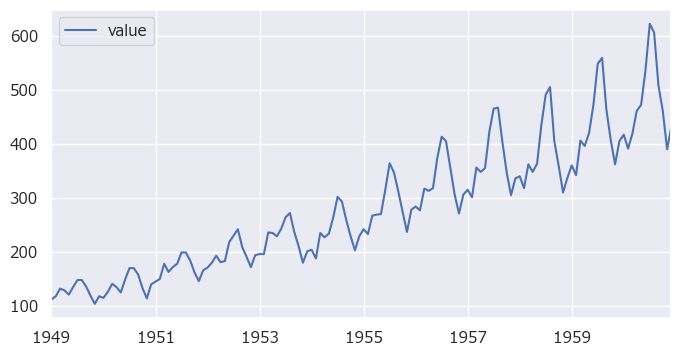

In [5]:
# 参考：素朴にpandasのplot関数を適用

# グラフサイズの指定
fig, ax = plt.subplots(figsize=(8, 4))

# 折れ線グラフを描く
air_passengers.plot(ax=ax)

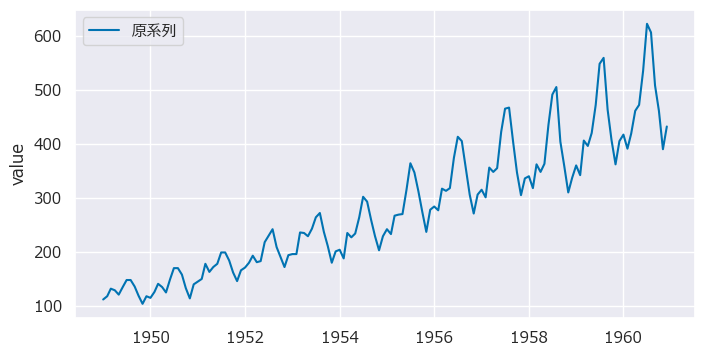

In [6]:
# 参考：sktimeのplot_series関数を利用

# 折れ線グラフを描く
fig, ax = plot_series(air_passengers, labels=['原系列'], markers=[''])

# グラフサイズの指定
fig.set_size_inches(8, 4)

### データの分割

In [7]:
# 訓練データとテストデータに分割する
train, test = temporal_train_test_split(air_passengers, test_size=36)
test.index

PeriodIndex(['1958-01', '1958-02', '1958-03', '1958-04', '1958-05', '1958-06',
             '1958-07', '1958-08', '1958-09', '1958-10', '1958-11', '1958-12',
             '1959-01', '1959-02', '1959-03', '1959-04', '1959-05', '1959-06',
             '1959-07', '1959-08', '1959-09', '1959-10', '1959-11', '1959-12',
             '1960-01', '1960-02', '1960-03', '1960-04', '1960-05', '1960-06',
             '1960-07', '1960-08', '1960-09', '1960-10', '1960-11', '1960-12'],
            dtype='period[M]')

In [8]:
# 予測期間
fh = np.arange(1, len(test) + 1)
fh

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13,
       14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26,
       27, 28, 29, 30, 31, 32, 33, 34, 35, 36])

### sktimeによる予測

#### 持続予測(ナイーブ予測)

In [9]:
# 予測手法の指定
naive_forecaster = NaiveForecaster(strategy='last')

# データへの当てはめ
naive_forecaster.fit(train)

# 予測の実施
naive_pred = naive_forecaster.predict(fh)

In [10]:
# 参考：fitとpredictを同時に実行
print(naive_forecaster.fit_predict(y=train, fh=fh).head(3))

         value
1958-01  336.0
1958-02  336.0
1958-03  336.0


#### 季節ナイーブ予測

In [11]:
# 予測手法の指定
s_naive_forecaster = NaiveForecaster(strategy='last', sp=12)

# データへの当てはめ
s_naive_forecaster.fit(train)

# 予測の実施
s_naive_pred = s_naive_forecaster.predict(fh)

#### 平均値予測

In [12]:
# 予測手法の指定
mean_forecaster = NaiveForecaster(strategy='mean')

# データへの当てはめ
mean_forecaster.fit(train)

# 予測の実施
mean_pred = mean_forecaster.predict(fh)

#### 移動平均法による予測

In [13]:
# 予測手法の指定
ma_forecaster = NaiveForecaster(strategy='mean', window_length=12)

# データへの当てはめ
ma_forecaster.fit(train)

# 予測の実施
ma_pred = ma_forecaster.predict(fh)

#### ドリフト予測

In [14]:
# 予測手法の指定
drift_forecaster = NaiveForecaster(strategy='drift')

# データへの当てはめ
drift_forecaster.fit(train)

# 予測の実施
drift_pred = drift_forecaster.predict(fh)

### sktimeによるクロスバリデーション

#### 1時点先予測による評価

In [15]:
# CVの設定
# 1時点先予測を、データを1個ずつ増やしながら何度も繰り返す
cv = ExpandingWindowSplitter(fh=1, initial_window=1, step_length=1)

In [16]:
# CVの実行
cv_df = evaluate(forecaster=naive_forecaster, cv=cv, y=train, 
                 scoring=MeanAbsoluteError())
print(cv_df.head(3))

   test_MeanAbsoluteError  fit_time  pred_time  len_train_window   cutoff
0                     6.0  0.001365   0.004416                 1  1949-01
1                    14.0  0.001189   0.003434                 2  1949-02
2                     3.0  0.001129   0.003603                 3  1949-03


In [17]:
# 1時点先予測のMAEの平均値
cv_df.iloc[:, 0].mean()

20.317757009345794

In [18]:
# 参考：MASEで使う標準エラー(naive_error)と一致する
np.abs(train['1949-02':'1957-12'].values - train['1949-01':'1957-11'].values).mean()

20.317757009345794

#### 12時点先予測による評価

In [19]:
# CVの設定
# 12時点先予測を、データを12個ずつ増やしながら何度も繰り返す
cv = ExpandingWindowSplitter(fh=np.arange(1,13), initial_window=24, 
                             step_length=12)

# CVの実行
cv_df = evaluate(forecaster=naive_forecaster, cv=cv, y=train,
                 scoring=MeanAbsoluteError(), return_data=True)

In [20]:
# 12時点先予測のMAEの平均値
cv_df.iloc[:, 0].mean()

43.511904761904766

In [21]:
# 参考：CVの結果の詳細
cv_df.head(3)

,test_MeanAbsoluteError,fit_time,pred_time,len_train_window,cutoff,y_train,y_test,y_pred
0,30.166667,0.001329,0.004528,24,1950-12,value 1949-01 112 1949-02 118 1...,value 1951-01 145 1951-02 150 1...,value 1951-01 140.0 1951-02 140.0 1...
1,31.000000,0.001232,0.003712,36,1951-12,value 1949-01 112 1949-02 118 1...,value 1952-01 171 1952-02 180 1...,value 1952-01 166.0 1952-02 166.0 1...
2,33.333333,0.001154,0.003466,48,1952-12,value 1949-01 112 1949-02 118 1...,value 1953-01 196 1953-02 196 1...,value 1953-01 194.0 1953-02 194.0 1...


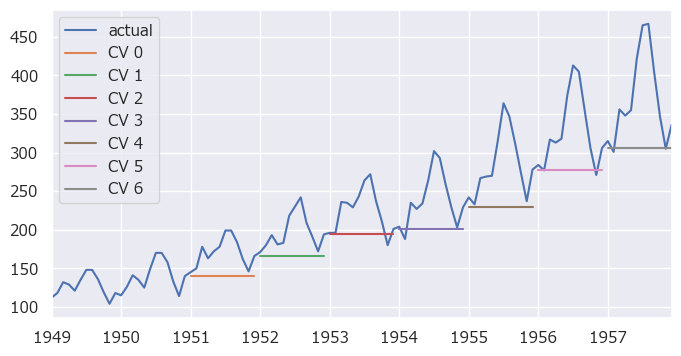

In [22]:
# グラフの大きさなどの設定
fig, ax = plt.subplots(figsize=(8, 4))

# 実データのプロット
train.plot(ax=ax)

# CVの結果をまとめてグラフにする
for i in np.arange(0, cv_df.shape[0]):
    cv_df['y_pred'].iloc[i].plot(ax=ax)

# 凡例
plt.legend(['actual'] + ['CV ' + str(i) for i in range(cv_df.shape[0])])

### パイプラインの利用

#### 事例1：季節調整＋トレンド除去＋ナイーブ予測

In [23]:
# 予測手法の指定
# 前処理から予測までを1つのパイプラインにまとめる
pipe_forecaster_1 = TransformedTargetForecaster(
    [
        ('deseasonalize', Deseasonalizer(model='multiplicative', sp=12)),
        ('detrend', Detrender(forecaster=PolynomialTrendForecaster(degree=1), 
                              model='multiplicative')),
        ('forecast', NaiveForecaster(strategy='last')),
    ]
)


In [24]:
# データへの当てはめ
pipe_forecaster_1.fit(train)

# 予測の実施
pipe_pred_1 = pipe_forecaster_1.predict(fh)

# 予測精度
mean_absolute_error(test, pipe_pred_1)

23.600721546680017

In [25]:
# CVの設定
# 12時点先予測を、データを12個ずつ増やしながら何度も繰り返す
cv = ExpandingWindowSplitter(fh=np.arange(1,13), initial_window=24, 
                             step_length=12)

# CVの実行
cv_df = evaluate(forecaster=pipe_forecaster_1, cv=cv, y=train, 
                 scoring=MeanAbsoluteError())

# MAEの平均
cv_df.iloc[:, 0].mean()

11.810688058465244

#### 事例2：差分によるトレンド除去＋季節ナイーブ

In [26]:
# 予測手法の指定
# 前処理から予測までを1つのパイプラインにまとめる
pipe_forecaster_2 = TransformedTargetForecaster(
    [
        ('transform', Differencer(lags=[1])),
        ('forecast', NaiveForecaster(strategy='last', sp=12))
    ]
)

# データへの当てはめ
pipe_forecaster_2.fit(train)

# 予測の実施
pipe_pred_2 = pipe_forecaster_2.predict(fh)

# 予測精度
mean_absolute_error(test, pipe_pred_2)

17.805555555555557

In [27]:
# CVの実行
evaluate(forecaster=pipe_forecaster_2, cv=cv, y=train, 
         scoring=MeanAbsoluteError()).iloc[:, 0].mean()

11.13095238095238

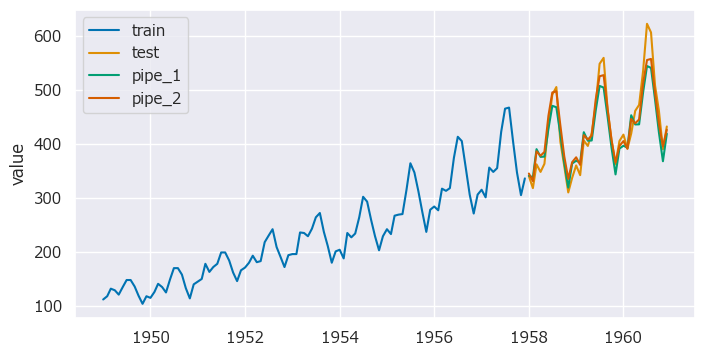

In [28]:
# 予測結果の可視化
fig, ax = plot_series(train, test, pipe_pred_1, pipe_pred_2, 
                      labels=['train', 'test', 'pipe_1', 'pipe_2'], 
                      markers=np.tile('', 4))
fig.set_size_inches(8, 4)

### ハイパーパラメータのチューニング

In [29]:
# 持続予測
naive_forecaster = NaiveForecaster(strategy='last', sp=1)

# 持続予測のハイパーパラメータの候補
param_grid = {'sp': np.arange(1,13)}

# 予測器の作成
best_naive_forecaster = ForecastingGridSearchCV(
    naive_forecaster, strategy='refit', cv=cv, param_grid=param_grid, 
    scoring=MeanAbsoluteError()
)

In [30]:
# データへの当てはめ
best_naive_forecaster.fit(train)

# 選ばれたパラメータ
best_naive_forecaster.best_params_

{'sp': 12}

In [31]:
# 参考：CVの結果の詳細
print(best_naive_forecaster.cv_results_)

    mean_test_MeanAbsoluteError  mean_fit_time  mean_pred_time      params  \
0                     43.511905       0.002088        0.006700   {'sp': 1}   
1                     56.630952       0.001757        0.013251   {'sp': 2}   
2                     52.178571       0.002072        0.014398   {'sp': 3}   
3                     47.000000       0.001545        0.011148   {'sp': 4}   
4                     49.702381       0.001769        0.013728   {'sp': 5}   
5                     41.273810       0.001811        0.013635   {'sp': 6}   
6                     43.500000       0.001449        0.012832   {'sp': 7}   
7                     48.119048       0.001885        0.016918   {'sp': 8}   
8                     41.285714       0.001690        0.014227   {'sp': 9}   
9                     37.761905       0.001984        0.016294  {'sp': 10}   
10                    35.571429       0.001725        0.017365  {'sp': 11}   
11                    33.083333       0.001675        0.014793  

In [32]:
# 予測の実施
best_naive_pred = best_naive_forecaster.predict(fh)

# 予測精度
mean_absolute_error(test, best_naive_pred)

60.083333333333336

### 予測手法の半自動選択

#### 事例1：複数の予測手法からの選択

In [33]:
# 予測器の候補一覧
forecast_options = MultiplexForecaster(
    forecasters=[
        ('s_naive', s_naive_forecaster),
        ('pipe_1',  pipe_forecaster_1),
        ('pipe_2',  pipe_forecaster_2)
    ]
)

# 以下の予測から1つを選ぶ
param_grid = {'selected_forecaster': ['s_naive', 'pipe_1', 'pipe_2']}

# 予測器の作成
cv_forecaster = ForecastingGridSearchCV(
    forecast_options, strategy='refit', cv=cv, param_grid=param_grid, 
    scoring=MeanAbsoluteError()
)

In [34]:
# データへの当てはめ
cv_forecaster.fit(train)

# CVで判断された最良の予測手法
cv_forecaster.best_params_

{'selected_forecaster': 'pipe_2'}

In [35]:
# 参考：CVの詳細な結果
print(cv_forecaster.cv_results_[['mean_test_MeanAbsoluteError', 'params']])

   mean_test_MeanAbsoluteError                              params
0                    33.083333  {'selected_forecaster': 's_naive'}
1                    11.810688   {'selected_forecaster': 'pipe_1'}
2                    11.130952   {'selected_forecaster': 'pipe_2'}


#### 事例2：対数変換の必要性の検討

In [36]:
# 前処理の有無＋予測器の候補
pipe_select = TransformedTargetForecaster(
    steps=[
        ('log', OptionalPassthrough(LogTransformer())),
        ('forecaster', MultiplexForecaster(
            forecasters=[
                ('s_naive', s_naive_forecaster),
                ('pipe_1',  pipe_forecaster_1),
                ('pipe_2',  pipe_forecaster_2)
            ]
        )),
    ]
)

# 対数変換の有無・対象となる予測方法の一覧
param_grid = {
    'log__passthrough': [True, False],
    'forecaster__selected_forecaster': ['s_naive', 'pipe_1', 'pipe_2'],
}

# 予測器の作成
cv_pipe_forecaster = ForecastingGridSearchCV(
    forecaster=pipe_select, param_grid=param_grid, 
    cv=cv, scoring=MeanAbsoluteError()
)

In [37]:
# データへの当てはめ
cv_pipe_forecaster.fit(train)

# CVで判断された最良の予測手法
cv_pipe_forecaster.best_params_

{'forecaster__selected_forecaster': 'pipe_1', 'log__passthrough': False}

In [38]:
# CVの結果のうち、必要な列だけをコピーする
result_df = cv_pipe_forecaster.cv_results_[
    ['mean_test_MeanAbsoluteError', 'params']].copy()

# パラメータの値だけをとり出して格納する
result_df['params'] = result_df['params'].apply(lambda x: list(x.values()))

# 結果の表示
print(result_df)

   mean_test_MeanAbsoluteError            params
0                    33.083333   [s_naive, True]
1                    33.083333  [s_naive, False]
2                    11.810688    [pipe_1, True]
3                     9.090768   [pipe_1, False]
4                    11.130952    [pipe_2, True]
5                    10.881038   [pipe_2, False]


In [39]:
# 予測の実施
best_pred = cv_pipe_forecaster.predict(fh)

# 予測精度
mean_absolute_error(test, best_pred)

36.03614258141145